# Half-Normal Distribution with NGBoost

**Problem**: Regression on strictly positive outcomes with a mode at zero —
a single-parameter distribution for non-negative data.

**When to use**:
- Error magnitudes: modeling |residual| or absolute deviations
- Response times: simple model when times are clustered near zero
- Any positive outcome where a single scale parameter suffices

**Parameters**: Single parameter `scale` (log-transformed).
Mean = scale * sqrt(2/π). The distribution is the positive half of
a Normal(0, scale), folded at zero.

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import HalfNormal

## 1. Generate synthetic positive data

In [3]:
np.random.seed(42)
n_samples = 1000
X = np.random.randn(n_samples, 5)

# True scale depends on features
true_scale = np.exp(1.0 + 0.5 * X[:, 0])
Y = np.abs(np.random.normal(0, true_scale))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.3f}, {Y.max():.2f}]")
print(f"Y mean: {Y.mean():.2f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0.002, 20.39]
Y mean: 2.49
Train: 800, Test: 200


## 2. Train NGBoost

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=5,
    random_state=None,
)
ngb = NGBRegressor(
    Dist=HalfNormal,
    n_estimators=500,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

Training complete.


## 3. Predictions and parameters

In [5]:
dists = ngb.pred_dist(X_test)
Y_pred = ngb.predict(X_test)

print("Estimated scale (first 5 test samples):")
print(f"  scale: {dists.scale[:5].round(3)}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):          {Y_test[:5].round(2)}")

Estimated scale (first 5 test samples):
  scale: [0.922 2.002 4.845 1.631 1.081]

Predicted mean (first 5): [0.74 1.6  3.87 1.3  0.86]
Actual (first 5):          [1.64 2.51 1.57 0.18 0.94]


## 4. Quantiles and prediction intervals

In [6]:
q10 = dists.ppf(0.1)
q50 = dists.ppf(0.5)
q90 = dists.ppf(0.9)

print("Quantiles (first 5 test samples):")
print(f"  10th: {q10[:5].round(2)}")
print(f"  50th: {q50[:5].round(2)}")
print(f"  90th: {q90[:5].round(2)}")

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"\n80% prediction interval coverage: {coverage:.1%} (target: 80%)")

Quantiles (first 5 test samples):
  10th: [0.12 0.25 0.61 0.21 0.14]
  50th: [0.62 1.35 3.27 1.1  0.73]
  90th: [1.52 3.29 7.97 2.68 1.78]

80% prediction interval coverage: 64.0% (target: 80%)


## 5. Visualize

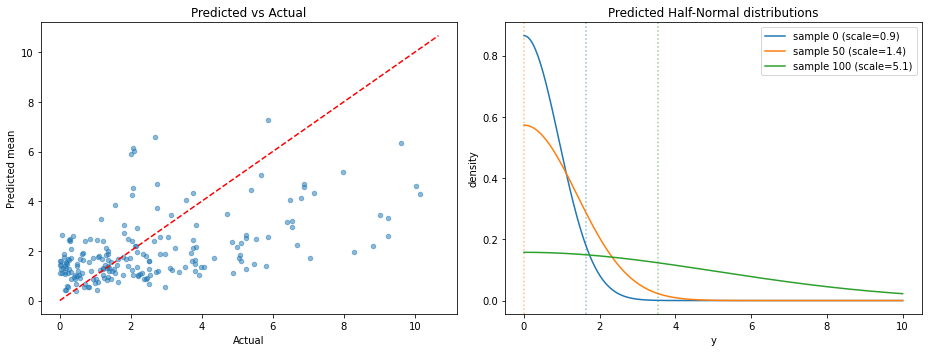

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [0, max(Y_test.max(), Y_pred.max()) * 1.05]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

ax = axes[1]
x = np.linspace(0, 10, 300)
for i in [0, 50, 100]:
    s_i = dists.scale[i]
    pdf = scipy.stats.halfnorm.pdf(x, scale=s_i)
    ax.plot(x, pdf, label=f"sample {i} (scale={s_i:.1f})")
    ax.axvline(Y_test[i], color=ax.lines[-1].get_color(), linestyle=":", alpha=0.5)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted Half-Normal distributions")
ax.legend()

plt.tight_layout()
plt.show()